# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material

- Tutorial 3
- Huggingface documentation
- Huggingface hub

# Introduction

You are tasked to address the [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [1]:
!pip install pandas
!pip install numpy
!pip install nltk
!pip install tensorflow
!pip install scikit-learn
!pip install torch
!pip install -U bitsandbytes
!pip install accelerate
!pip install transformers
!pip install langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.9 MB/s eta 0:00:00


In [14]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `NLP_PROJ` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `NLP_PROJ`

After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [15]:
#0. IMPORTS
import urllib
from pathlib import Path
import zipfile
import pandas as pd
from tqdm import tqdm

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

In [16]:
class DownloadProgressBar(tqdm):
    """
    A class to represent a download progress bar, extending the tqdm class.
    """
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    """
    Downloads a file from the given URL to the specified download path, displaying a progress bar.
    """
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

In [17]:
def download_dataset(download_path: Path, url: str):
    """
    Downloads a dataset from a given URL to a specified download path.

    Inputs:
      download_path (Path): The path where the dataset will be downloaded.
      url (str): The URL from which to download the dataset.

    Outputs:
        None
    """
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")


def extract_dataset(download_path: Path, extract_path: Path):
    """
    Extracts a dataset from a ZIP file.

    Inputs:
      download_path (Path): The path to the ZIP file to be extracted.
      extract_path (Path): The directory where the contents of the ZIP file will be extracted.

    Outputs:
        None
    """
    print("Extracting dataset... (it may take a while...)")
    if zipfile.is_zipfile(download_path):
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction completed!")
    else:
        print("Error: The downloaded file is not a ZIP file.")

In [18]:
# Define paths and URL
url = "https://github.com/nlp-unibo/nlp-course-material/archive/refs/heads/main.zip"
dataset_name = "Exist"
dataset_folder = Path.cwd().joinpath("Datasets")
dataset_folder.mkdir(exist_ok=True)
download_path = dataset_folder.joinpath(f"{dataset_name}.zip")

# Download and extract
download_dataset(download_path, url)
extract_dataset(download_path, dataset_folder)

main.zip: 4.58MB [00:01, 3.95MB/s]


Download complete!
Extracting dataset... (it may take a while...)
Extraction completed!


In [19]:
import os

# Define the path where the ZIP file should have been extracted
extracted_path = dataset_folder

# Check and print the directory structure
print("Contents of the extracted dataset folder:")
for root, dirs, files in os.walk(extracted_path):
    level = root.replace(str(extracted_path), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

Contents of the extracted dataset folder:
Datasets/
    Exist.zip
    nlp-course-material-main/
        .gitignore
        README.md
        LICENSE
        .DS_Store
        2024-2025/
            README.md
            .DS_Store
            report_LaTeX_template.zip
            Tutorial 3/
                Tutorial 3.ipynb
                images/
                    collator.png
            Assignment 2/
                Assignment2-2425.ipynb
                data/
                    a2_test.csv
                    demonstrations.csv
            Seminar Speech/
                seminar_speech.ipynb
                audio_files/
                    hello_sound.wav
            Assignment 1/
                .DS_Store
                Assignment1-2425.ipynb
                data/
                    validation.json
                    training.json
                    test.json
        .idea/
            misc.xml
            .gitignore
            vcs.xml
            modules.xml
            nl

In [20]:
# Define the path to the dataset folder and select a CSV file
data_folder = dataset_folder.joinpath("nlp-course-material-main", "2024-2025", "Assignment 2", "data")
data_file = data_folder.joinpath("a2_test.csv")

# Load the CSV file and encode it as a pandas DataFrame
if data_file.is_file():
    a2_df = pd.read_csv(data_file)

    # Inspect the loaded data
    print("Loaded data structure:", type(a2_df))
    print("Number of entries:", len(a2_df))
    print("First few rows:")
    print(a2_df.head())
else:
    print(f"File {data_file} does not exist.")


Loaded data structure: <class 'pandas.core.frame.DataFrame'>
Number of entries: 300
First few rows:
                  rewire_id  \
0  sexism2022_english-17133   
1  sexism2022_english-14197   
2   sexism2022_english-3018   
3   sexism2022_english-5301   
4  sexism2022_english-17796   

                                                text label_sexist  
0  The boys must be gaming because there goes the...   not sexist  
1  Look at those eyes. Either someone unexpectedl...       sexist  
2                  Old man mogs everyone in this sub   not sexist  
3  Excellent, I was just looking at another post ...   not sexist  
4  So you run back to daddy whenever you need hel...       sexist  


# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Define a separate section of your notebook for the model.
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Notes

1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.

2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

In [21]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

In [22]:
def set_generation_config(model,tokenizer):
    """
        Configures the generation settings for a given model and tokenizer.

        Inputs:
            model: The model for which the generation configuration is to be set.
            tokenizer: The tokenizer associated with the model.

        Outputs:
            generation_config: The updated generation configuration with specified settings.
    """
    generation_config = model.generation_config
    generation_config.max_new_tokens = 2
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.temperature = 0.2
    generation_config.num_return_sequences = 1
    return generation_config

In [23]:
#Mistral-7B-Instruct-v0.3 initialization
model_card_v3 = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer_v3 = AutoTokenizer.from_pretrained(model_card_v3)
tokenizer_v3.pad_token = tokenizer_v3.eos_token

terminators = [
    tokenizer_v3.eos_token_id,
    tokenizer_v3.convert_tokens_to_ids("<|eot_id|>")
]

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_v3 = AutoModelForCausalLM.from_pretrained(
    model_card_v3,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

generation_config_v3 = set_generation_config(model_v3,tokenizer_v3)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [24]:
#Mistral-7B-Instruct-v0.2 initialization
model_card_v2 = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer_v2 = AutoTokenizer.from_pretrained(model_card_v2)
tokenizer_v2.pad_token = tokenizer_v2.eos_token

terminators = [
    tokenizer_v2.eos_token_id,
    tokenizer_v2.convert_tokens_to_ids("<|eot_id|>")
]

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_v2 = AutoModelForCausalLM.from_pretrained(
    model_card_v2,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

generation_config_v2 = set_generation_config(model_v2,tokenizer_v2)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [25]:
#A dictionary containing models and their corresponding tokenizers and generation configurations.
'''
 Note:
  This dictionary is created to respect the requirements of the generate_responses function,
  where you cannot pass the tokenizer and the generation_config as parameters to the function.
'''
models_dict = {
    model_v3 : {
        "tokenizer" : tokenizer_v3,
        "generation_config" : generation_config_v3
    },
   model_v2 : {
        "tokenizer" : tokenizer_v2,
        "generation_config" : generation_config_v2
    }
}

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [26]:
#Extract the 'text' column from the DataFrame `a2_df` and converts it to a list of texts.
texts = a2_df['text'].tolist()

In [27]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [28]:
'''
We defined a global variable to store the few-shot examples.
This way, we can use the prepare_prompts function for both simple and few-shot prompts
without changing the parameter assignments of prepare_prompts.
'''
examples=''

In [29]:
def format_simple_prompt(text, prompt_template):
    """
    Formats a simple prompt using the provided text and prompt template.

    Inputs:
        text (str): The text to be inserted into the prompt template.
        prompt_template (list): The prompt template to use.

    Outputs:
        formatted_prompt (list): The formatted prompt (text + prompt_template)
    """
    formatted_prompt = [
        {
            'role': prompt_template[0]['role'],
            'content': prompt_template[0]['content']
        },
        {
            'role': prompt_template[1]['role'],
            'content': prompt_template[1]['content'].format(text=text)
        }
    ]
    return formatted_prompt

In [30]:
def format_few_shot_prompt(text, prompt_template, examples):
    """
    Formats a few-shot prompt using the provided text, prompt template, and examples.

    Inputs:
        text (str): The main text to be included in the prompt.
        prompt_template (list): The prompt template to use.
        examples (list): A list of example strings to be included in the prompt.

    Outputs:
        formatted_prompt (list): The formatted prompt (text + examples +prompt_template)
    """
    formatted_examples = "\n".join(examples)
    formatted_prompt = [
        {
            'role': prompt_template[0]['role'],
            'content': prompt_template[0]['content']
        },
        {
            'role': prompt_template[1]['role'],
            'content': prompt_template[1]['content'].format(text=text, examples=formatted_examples)
        }
    ]
    return formatted_prompt

In [31]:
import re

def prepare_prompts(texts, prompt_template, tokenizer):
    """
        This function format input text samples into instructions prompts.

        Inputs:
          texts: input texts to classify via prompting
          prompt_template: the prompt template provided in this assignment
          tokenizer: the transformers Tokenizer object instance associated with the chosen model card

        Outputs:
          input texts to classify in the form of instruction prompts
    """
    tokenized_prompts = []

    for text in texts:
        if re.search(r"\{examples\}", prompt_template[1]['content']):
          formatted_prompt = format_few_shot_prompt(text, prompt_template, examples)
        else:
          formatted_prompt = format_simple_prompt(text, prompt_template)

        # Convert the formatted prompt into a single string for tokenization
        prompt_str = f"{formatted_prompt[0]['content']}\n\n{formatted_prompt[1]['content']}"

        # Tokenize the formatted prompt
        tokenized_prompt = tokenizer(
            prompt_str,
            return_tensors="pt",
            padding=True,
            truncation=True
        )

        tokenized_prompts.append(tokenized_prompt)

    return tokenized_prompts

### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [32]:
def generate_responses(model, prompt_examples):
    """
        This function implements the inference loop for a LLM model.
        Given a set of examples, the model is tasked to generate a response.

        Inputs:
          model: LLM model instance for prompting
          prompt_examples: pre-processed text samples

        Outputs:
          generated responses
    """
    responses = []

    for idx, example in enumerate(prompt_examples):
        # Move input tensors to the model's device
        input_ids = example['input_ids'].to(model.device)
        attention_mask = example['attention_mask'].to(model.device)

        # Generate the response
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=models_dict[model]["generation_config"],
            do_sample=False,
            use_cache=True
        )

        # Decode the generated output
        response = models_dict[model]["tokenizer"].batch_decode(outputs, skip_special_tokens=True)[0]
        responses.append(response)

        # Print progress
        print(f"Processed prompt {idx + 1}/{len(prompt_examples)}: {response}")

    return responses

In [33]:
# Prepare the simple prompts for v0.2 model
simple_prompts_v2 = prepare_prompts(texts, prompt, models_dict[model_v2]["tokenizer"])

# Generate the simple responses for v0.2 model
simple_responses_v2 = generate_responses(model_v2, simple_prompts_v2)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Processed prompt 1/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
         NO.
Processed prompt 2/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        Look at those eyes. Either someone unexpectedly just fisted her up the dumper, or that bitch is certifiably a nutburger.

        ANSWER:
         YES
Processed prompt 3/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        Old man mogs everyone in this sub

        ANSWER:
         NO.
Processed prompt 4/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

    

In [34]:
# Prepare the simple prompts for v0.3 model
simple_prompts_v3 = prepare_prompts(texts, prompt, models_dict[model_v3]["tokenizer"])

# Generate the simple responses for v0.3 model
simple_responses_v3 = generate_responses(model_v3, simple_prompts_v3)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Processed prompt 1/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
         YES
Processed prompt 2/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        Look at those eyes. Either someone unexpectedly just fisted her up the dumper, or that bitch is certifiably a nutburger.

        ANSWER:
         YES
Processed prompt 3/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        Old man mogs everyone in this sub

        ANSWER:
         YES
Processed prompt 4/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

    

In [35]:
def process_response(response):
    """
      This function takes a textual response generated by the LLM
      and processes it to map the response to a binary label.

      Inputs:
        response: generated response from LLM

      Outputs:
        parsed binary response: return 1 if YES and 0 if NO
    """
    import re

    # Normalize response for consistent parsing
    response = response.strip().upper()
    # Extract the answer part after 'ANSWER:'
    matches = re.findall(r"ANSWER:\s*(YES|NO)\s*", response, re.MULTILINE)
    if matches:
      if matches[-1] == 'YES':
        return 1
      elif matches[-1] == 'NO':
        return 0
    else:
        raise ValueError(f"Error processing response: {response}. Regex not matched")

In [36]:
# Process responses into binary labels v0.2 model
binary_labels_base_v2 = []

for idx, response in enumerate(simple_responses_v2):
    try:
        binary_label = process_response(response)
        binary_labels_base_v2.append(binary_label)
        print(f"Response {idx + 1}: Binary Label: {binary_label}")
    except ValueError as e:
        print(f"Error processing response {idx + 1}: {e}")
        print(f"Full Response: {response}")

Response 1: Binary Label: 0
Response 2: Binary Label: 1
Response 3: Binary Label: 0
Response 4: Binary Label: 1
Response 5: Binary Label: 1
Response 6: Binary Label: 1
Response 7: Binary Label: 1
Response 8: Binary Label: 0
Response 9: Binary Label: 0
Response 10: Binary Label: 1
Response 11: Binary Label: 0
Response 12: Binary Label: 1
Response 13: Binary Label: 1
Response 14: Binary Label: 1
Response 15: Binary Label: 0
Response 16: Binary Label: 0
Response 17: Binary Label: 1
Response 18: Binary Label: 0
Response 19: Binary Label: 0
Response 20: Binary Label: 1
Response 21: Binary Label: 1
Response 22: Binary Label: 1
Response 23: Binary Label: 1
Response 24: Binary Label: 0
Response 25: Binary Label: 0
Response 26: Binary Label: 1
Response 27: Binary Label: 1
Response 28: Binary Label: 1
Response 29: Binary Label: 1
Response 30: Binary Label: 0
Response 31: Binary Label: 1
Response 32: Binary Label: 1
Response 33: Binary Label: 0
Response 34: Binary Label: 1
Response 35: Binary Lab

In [37]:
# Process responses into binary labels v0.3 model
binary_labels_base_v3 = []

for idx, response in enumerate(simple_responses_v3):
    try:
        binary_label = process_response(response)
        binary_labels_base_v3.append(binary_label)
        print(f"Response {idx + 1}: Binary Label: {binary_label}")
    except ValueError as e:
        print(f"Error processing response {idx + 1}: {e}")
        print(f"Full Response: {response}")

Response 1: Binary Label: 1
Response 2: Binary Label: 1
Response 3: Binary Label: 1
Response 4: Binary Label: 1
Response 5: Binary Label: 1
Response 6: Binary Label: 1
Response 7: Binary Label: 1
Response 8: Binary Label: 0
Response 9: Binary Label: 0
Response 10: Binary Label: 1
Response 11: Binary Label: 1
Response 12: Binary Label: 1
Response 13: Binary Label: 1
Response 14: Binary Label: 1
Response 15: Binary Label: 0
Response 16: Binary Label: 1
Response 17: Binary Label: 1
Response 18: Binary Label: 1
Response 19: Binary Label: 1
Response 20: Binary Label: 1
Response 21: Binary Label: 1
Response 22: Binary Label: 1
Response 23: Binary Label: 1
Response 24: Binary Label: 0
Response 25: Binary Label: 0
Response 26: Binary Label: 1
Response 27: Binary Label: 1
Response 28: Binary Label: 1
Response 29: Binary Label: 1
Response 30: Binary Label: 0
Response 31: Binary Label: 1
Response 32: Binary Label: 1
Response 33: Binary Label: 1
Response 34: Binary Label: 1
Response 35: Binary Lab

## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [38]:
from sklearn.metrics import accuracy_score
def compute_metrics(responses, y_true):
    """
      This function takes predicted and ground-truth labels and compute metrics.
      In particular, this function compute accuracy and fail-ratio metrics.
      This function internally invokes `process_response` to compute metrics.

      Inputs:
        responses: generated LLM responses
        y_true: ground-truth binary labels

      Outputs:
        dictionary containing desired metrics
    """
    # Convert each LLM response to a 0/1 label with process_response
    y_pred = [process_response(response) for response in responses]

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Compute fail ratio = fraction of incorrect predictions
    fail_ratio = 1.0 - accuracy

    return {
        "accuracy": accuracy,
        "fail_ratio": fail_ratio
    }

In [39]:
# Map the 'label_sexist' column in the DataFrame `a2_df` to binary values (1 for 'sexist' and 0 for 'not sexist').
y_true=a2_df["label_sexist"].map({'sexist': int(1), 'not sexist': int(0)})

In [40]:
#Compute simple prompt v0.2 model metrics
simple_metrics_v2=compute_metrics(simple_responses_v2,y_true)
print("Simple prompt v0.2 metrics:", simple_metrics_v2)

#Compute simple prompt v0.3 model metrics
simple_metrics_v3=compute_metrics(simple_responses_v3,y_true)
print("Simple prompt v0.3 metrics:",simple_metrics_v3)

Simple prompt v0.2 metrics: {'accuracy': 0.74, 'fail_ratio': 0.26}
Simple prompt v0.3 metrics: {'accuracy': 0.5866666666666667, 'fail_ratio': 0.41333333333333333}


# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [41]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [42]:
#Commented because it's just an example from the original assignment specifications
'''
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
'''

'\nprompt = [\n    {\n        \'role\': \'system\',\n        \'content\': \'You are an annotator for sexism detection.\'\n    },\n    {\n        \'role\': \'user\',\n        \'content\': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.\n\n        EXAMPLES:\n        TEXT: **example 1**\n        ANSWER: YES\n        TEXT: **example 2**\n        ANSWER: NO\n\n        TEXT:\n        {text}\n\n        ANSWER:\n        """\n    }\n]\n'

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [43]:
# Define the path to the dataset folder and select a CSV file
data_folder = dataset_folder.joinpath("nlp-course-material-main", "2024-2025", "Assignment 2", "data")
data_file = data_folder.joinpath("demonstrations.csv")

# Load the CSV file and encode it as a pandas DataFrame
if data_file.is_file():
    demonstrations_df = pd.read_csv(data_file)

    # Inspect the loaded data
    print("Loaded data structure:", type(demonstrations_df))
    print("Number of entries:", len(demonstrations_df))
    print("First few rows:")
    print(demonstrations_df.head())
else:
    print(f"File {data_file} does not exist.")


Loaded data structure: <class 'pandas.core.frame.DataFrame'>
Number of entries: 1000
First few rows:
                  rewire_id  \
0  sexism2022_english-10348   
1   sexism2022_english-7950   
2   sexism2022_english-7742   
3  sexism2022_english-16170   
4   sexism2022_english-9857   

                                                text label_sexist  
0  I would never have my kid go to a daycare with...   not sexist  
1           Democrat women are so butt fucking ugly.       sexist  
2  If you really wanted to twist the knife you’d ...   not sexist  
3  Those women are pro-rape. They didn’t care abo...       sexist  
4  Married a bitch... Is it the standard scenario...       sexist  


In [44]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """
  # The first num_per_class examples are selected from the df
  sexist_examples = demonstrations[demonstrations["label_sexist"] == "sexist"].head(num_per_class)
  not_sexist_examples = demonstrations[demonstrations["label_sexist"] == "not sexist"].head(num_per_class)

  few_shot_examples = []

  # Build example strings for sexist examples (label = "YES")
  for _, row in sexist_examples.iterrows():
      few_shot_examples.append(
          f"TEXT: {row['text']}\nANSWER: YES"
      )

  # Build example strings for not-sexist examples (label = "NO")
  for _, row in not_sexist_examples.iterrows():
      few_shot_examples.append(
          f"TEXT: {row['text']}\nANSWER: NO"
      )

  return few_shot_examples

In [45]:
#Build few shot examples
examples = build_few_shot_demonstrations(demonstrations_df, 3)
examples

['TEXT: Democrat women are so butt fucking ugly.\nANSWER: YES',
 'TEXT: Those women are pro-rape. They didn’t care about your consent. You need to publicly shame them and ruin their lives.\nANSWER: YES',
 'TEXT: Married a bitch... Is it the standard scenario where her hypergamy caused her to cheat?\nANSWER: YES',
 'TEXT: I would never have my kid go to a daycare with a nog working there. But I also would keep it to myself. Also that font she used should be considered a hate crime\nANSWER: NO',
 'TEXT: If you really wanted to twist the knife you’d be extra nice to her as you tell her no. But why waste your time.\nANSWER: NO',
 'TEXT: She says this is not normal. Where has she been for the last two years? Trump is the new normal.\nANSWER: NO']

In [46]:
# Prepare the few shot prompts for v0.2 model
few_shot_prompts_v2 = prepare_prompts(texts, prompt, models_dict[model_v2]["tokenizer"])

# Generate few shot responses for v0.2 model
few_shot_responses_v2 = generate_responses(model_v2, few_shot_prompts_v2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Democrat women are so butt fucking ugly.
ANSWER: YES
TEXT: Those women are pro-rape. They didn’t care about your consent. You need to publicly shame them and ruin their lives.
ANSWER: YES
TEXT: Married a bitch... Is it the standard scenario where her hypergamy caused her to cheat?
ANSWER: YES
TEXT: I would never have my kid go to a daycare with a nog working there. But I also would keep it to myself. Also that font she used should be considered a hate crime
ANSWER: NO
TEXT: If you really wanted to twist the knife you’d be extra nice to her as you tell her no. But why waste your time.
ANSWER: NO
TEXT: She says this is not normal. Where has she been for the last two years? Trump is the new normal.
ANSWER: NO

        TEXT:
        Go for more traditional women. They cheat at a far lower rate than city girls.

        

In [47]:
# Prepare the few shot prompts for v0.3 model
few_shot_prompts_v3 = prepare_prompts(texts, prompt, models_dict[model_v3]["tokenizer"])

# Generate few shot responses for v0.3 model
few_shot_responses_v3 = generate_responses(model_v3, few_shot_prompts_v3)

Output streaming troncato alle ultime 5000 righe.
TEXT: She says this is not normal. Where has she been for the last two years? Trump is the new normal.
ANSWER: NO

        TEXT:
        No. First my mom became a whore after dad left and was a huge bitch! Oh god, why won't she love me?!

        ANSWER:
         YES
Processed prompt 84/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Democrat women are so butt fucking ugly.
ANSWER: YES
TEXT: Those women are pro-rape. They didn’t care about your consent. You need to publicly shame them and ruin their lives.
ANSWER: YES
TEXT: Married a bitch... Is it the standard scenario where her hypergamy caused her to cheat?
ANSWER: YES
TEXT: I would never have my kid go to a daycare with a nog working there. But I also would keep it to myself. Also that font she used should be considered a hate crime
ANSWER: NO
TEXT: If you reall

In [48]:
# Process responses into binary labels v0.2 model
binary_labels_few_v2 = []

for idx, response in enumerate(few_shot_responses_v2):
    try:
        binary_label = process_response(response)
        binary_labels_few_v2.append(binary_label)
        print(f"Response {idx + 1}: Binary Label: {binary_label}")
    except ValueError as e:
        print(f"Error processing response {idx + 1}: {e}")
        print(f"Full Response: {response}")

Response 1: Binary Label: 0
Response 2: Binary Label: 1
Response 3: Binary Label: 0
Response 4: Binary Label: 1
Response 5: Binary Label: 1
Response 6: Binary Label: 0
Response 7: Binary Label: 0
Response 8: Binary Label: 0
Response 9: Binary Label: 0
Response 10: Binary Label: 0
Response 11: Binary Label: 0
Response 12: Binary Label: 1
Response 13: Binary Label: 0
Response 14: Binary Label: 1
Response 15: Binary Label: 0
Response 16: Binary Label: 0
Response 17: Binary Label: 0
Response 18: Binary Label: 0
Response 19: Binary Label: 0
Response 20: Binary Label: 0
Response 21: Binary Label: 1
Response 22: Binary Label: 1
Response 23: Binary Label: 0
Response 24: Binary Label: 0
Response 25: Binary Label: 0
Response 26: Binary Label: 1
Response 27: Binary Label: 0
Response 28: Binary Label: 0
Response 29: Binary Label: 1
Response 30: Binary Label: 0
Response 31: Binary Label: 0
Response 32: Binary Label: 1
Response 33: Binary Label: 0
Response 34: Binary Label: 0
Response 35: Binary Lab

In [49]:
# Process responses into binary labels v0.3 model
binary_labels_few_v3 = []

for idx, response in enumerate(few_shot_responses_v3):
    try:
        binary_label = process_response(response)
        binary_labels_few_v3.append(binary_label)
        print(f"Response {idx + 1}: Binary Label: {binary_label}")
    except ValueError as e:
        print(f"Error processing response {idx + 1}: {e}")
        print(f"Full Response: {response}")

Response 1: Binary Label: 0
Response 2: Binary Label: 1
Response 3: Binary Label: 0
Response 4: Binary Label: 1
Response 5: Binary Label: 1
Response 6: Binary Label: 1
Response 7: Binary Label: 1
Response 8: Binary Label: 0
Response 9: Binary Label: 0
Response 10: Binary Label: 1
Response 11: Binary Label: 0
Response 12: Binary Label: 1
Response 13: Binary Label: 1
Response 14: Binary Label: 1
Response 15: Binary Label: 0
Response 16: Binary Label: 1
Response 17: Binary Label: 0
Response 18: Binary Label: 0
Response 19: Binary Label: 0
Response 20: Binary Label: 1
Response 21: Binary Label: 1
Response 22: Binary Label: 1
Response 23: Binary Label: 1
Response 24: Binary Label: 0
Response 25: Binary Label: 0
Response 26: Binary Label: 1
Response 27: Binary Label: 1
Response 28: Binary Label: 0
Response 29: Binary Label: 1
Response 30: Binary Label: 0
Response 31: Binary Label: 1
Response 32: Binary Label: 1
Response 33: Binary Label: 0
Response 34: Binary Label: 0
Response 35: Binary Lab

In [50]:
#Compute few shot prompt v0.2 model metrics
few_shot_metrics_v2=compute_metrics(few_shot_responses_v2,y_true)
print("Few shot prompt v0.2 metrics:", few_shot_metrics_v2)

#Compute few shot prompt v0.3 model metrics
few_shot_metrics_v3=compute_metrics(few_shot_responses_v3,y_true)
print("Few shot prompt v0.3 metrics:",few_shot_metrics_v3)

Few shot prompt v0.2 metrics: {'accuracy': 0.6733333333333333, 'fail_ratio': 0.32666666666666666}
Few shot prompt v0.3 metrics: {'accuracy': 0.7333333333333333, 'fail_ratio': 0.2666666666666667}


## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

In [51]:
#Comparison in a df (table)
metrics_data = {
    "Model": ["Mistral 7B v0.2 - Simple", "Mistral 7B v0.3 - Simple", "Mistral 7B v0.2 - Few Shot", "Mistral 7B v0.3 - Few Shot"],
    "Accuracy": [simple_metrics_v2['accuracy'], simple_metrics_v3['accuracy'], few_shot_metrics_v2['accuracy'], few_shot_metrics_v3['accuracy']],
    "Fail Ratio": [simple_metrics_v2['fail_ratio'], simple_metrics_v3['fail_ratio'], few_shot_metrics_v2['fail_ratio'], few_shot_metrics_v3['fail_ratio']]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df.sort_values(by="Accuracy", ascending=False, ignore_index=True)


,Model,Accuracy,Fail Ratio
0,Mistral 7B v0.2 - Simple,0.740000,0.260000
1,Mistral 7B v0.3 - Few Shot,0.733333,0.266667
2,Mistral 7B v0.2 - Few Shot,0.673333,0.326667
3,Mistral 7B v0.3 - Simple,0.586667,0.413333


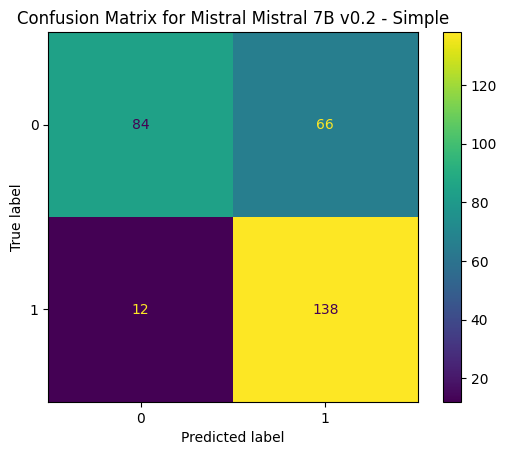

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred = [process_response(response) for response in simple_responses_v2]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Mistral Mistral 7B v0.2 - Simple")
plt.show()

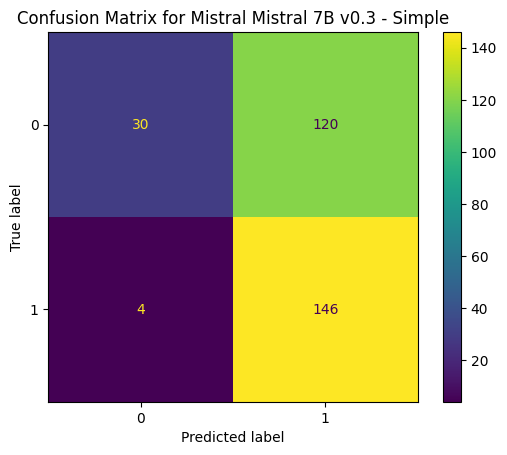

In [53]:
y_pred = [process_response(response) for response in simple_responses_v3]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Mistral Mistral 7B v0.3 - Simple")
plt.show()

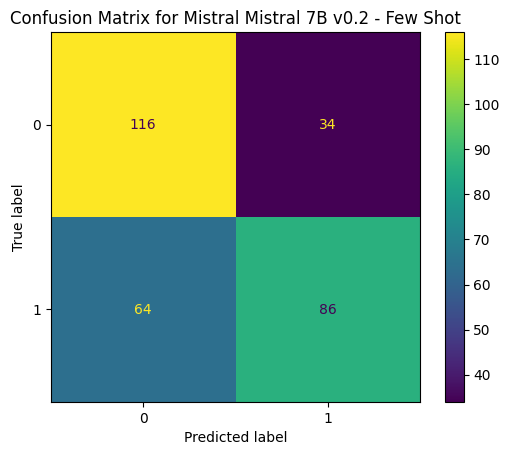

In [54]:
y_pred = [process_response(response) for response in few_shot_responses_v2]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Mistral Mistral 7B v0.2 - Few Shot")
plt.show()

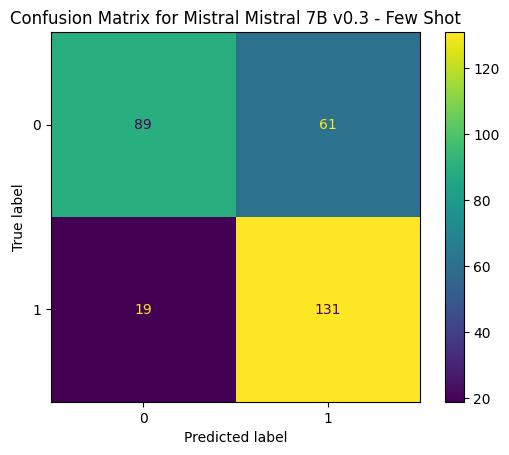

In [55]:
y_pred = [process_response(response) for response in few_shot_responses_v3]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Mistral Mistral 7B v0.3 - Few Shot")
plt.show()

##**Observations**
Surprisingly, the Mistral v0.2 with a simple prompt achieves the highest accuracy, while the Mistral v0.3 with a simple prompt performs the worst. The confusion matrices reveal a key pattern: the v0.3 models tend to produce many False Positives, labeling non-sexist tweets as sexist.
This observation led us to a hypothesis: the rising interest in aligning LLMs with ethics and human values, including gender equality, may have influenced the RLHF phase of v0.3. There might have been adjustments aimed at improving the model’s sensitivity to sexist content, however, this could inadvertently introduce a bias that increases the likelihood of misclassifying non-sexist content. It is essential to consider also alternative factors as well, such as differences in training data distribution.
From https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3:
Mistral-7B-v0.3 has the following changes compared to Mistral-7B-v0.2

1.  **Extended vocabulary to 32768**
2.   Supports v3 Tokenizer
3.   Supports function calling

 Nevertheless, with a few-shot prompt, the performance of v0.3 improves significantly by reducing the False Positive issue, nearly matching the accuracy of Mistral v0.2 with a simple prompt.

### **Dynamic Selection of the Examples**

Until now, we adopted a straightforward approach in the selection of the examples by choosing the **first examples** in the demonstration dataset. This naive method provided a baseline for comparison but did not account for any relationship between the current sample and the selected demonstrations.

To improve upon this, we experimented with a more dynamic approach. Specifically, we implemented a selection mechanism based on **semantic similarity**. In this strategy, examples for the demonstrations were dynamically chosen based on their semantic similarity to the current sample. The intuition behind this approach is that selecting examples more closely related to the current sample may provide better contextual relevance, potentially leading to improved model performance. Semantic similarity was measured using euclidean distance between the embedding vectors.
We used LangChain as library and an embedding model from HF for this experiment.

By comparing these two strategies, we aim to evaluate whether tailoring the demonstration examples to each sample improves the model's overall performances.


In [56]:
!pip install langchain
!pip install langchain_core
!pip install langchain_huggingface
!pip install langchain-community
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 48.8 MB/s eta 0:00:00


In [57]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_core.example_selectors import SemanticSimilarityExampleSelector


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


index = faiss.IndexFlatL2(len(embeddings.embed_query("NLP is great")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [58]:
def create_example_selectors(demonstrations, num_per_class=2):
  """
  Create example selectors for sexist and not sexist examples based on semantic similarity.

  Inputs:
    demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
    num_per_class (int, optional): The number of examples to select per class. Defaults to 2.

  Outputs:
    tuple: A tuple containing two SemanticSimilarityExampleSelector objects, one for sexist examples and one for not sexist examples.
  """
  sexist_examples = demonstrations[demonstrations["label_sexist"] == "sexist"]
  sexist_examples_dict = [
    {"input": row["text"], "output": 'YES'}
    for _, row in sexist_examples.iterrows()
]
  example_selector_sexist = SemanticSimilarityExampleSelector.from_examples(
    sexist_examples_dict,
    embeddings,
    vector_store,
    k=num_per_class,
    input_keys=["input"]
)

  not_sexist_examples = demonstrations[demonstrations["label_sexist"] == "not sexist"]
  not_sexist_examples_dict = [
  {"input": row["text"], "output": 'NO'}
  for _, row in not_sexist_examples.iterrows()
]
  example_selector_not_sexist = SemanticSimilarityExampleSelector.from_examples(
    not_sexist_examples_dict,
    embeddings,
    vector_store,
    k=num_per_class,
    input_keys=["input"]
)
  return example_selector_sexist, example_selector_not_sexist

In [59]:
def get_dynamic_examples(text,example_selector_sexist,example_selector_not_sexist):
    """
    Returns a list of formatted example texts based on the input text and example selectors.

    Inputs:
        text (str): The input text to be used for selecting examples.
        example_selector_sexist (object): An example selector with a method `select_examples` that selects sexist examples based on the input text.
        example_selector_not_sexist (object): An example selector with a method `select_examples` that selects not-sexist examples based on the input text.

    Outputs:
        formatted_examples: A list of formatted example strings.
    """
    selected_sexist_examples = example_selector_sexist.select_examples({"input": text})
    selected_not_sexist_examples = example_selector_not_sexist.select_examples({"input": text})

    selected_examples = selected_sexist_examples+selected_not_sexist_examples
    formatted_examples = [f"TEXT: {row['input']}\nANSWER: {row['output']}" for row in selected_examples]
    return formatted_examples


In [60]:
#An example of selected examples based on input
example_selector_sexist, example_selector_not_sexist=create_example_selectors(demonstrations_df,3)
dynamic_examples=get_dynamic_examples("I love democrats women",example_selector_sexist,example_selector_not_sexist)
dynamic_examples

['TEXT: Democrat women are so butt fucking ugly.\nANSWER: YES',
 "TEXT: Because a REAL MAN™ would marry some used up whore in her thirties who can't give him healthy kids! YEAH! Meanwhile, another democrat rapes toddlers. Hi, Bob Menendez. Hi Al Franken. Oh, and can't forget George Takei. Oh myyyyyy\nANSWER: YES",
 'TEXT: Anyone who doesn’t hate women is a cuck.\nANSWER: YES',
 "TEXT: REPOST if you're thankful your woman is not a liberal. [URL]\nANSWER: NO",
 'TEXT: Why are far-right wing women hot #af, #GabFam? #NSFW #GabAfterDark 😊\nANSWER: NO',
 'TEXT: Reminder that she votes for the party that enslaved blacks, lynched blacks, segregated blacks, and aborts blacks.\nANSWER: NO']

In [61]:
def prepare_dynamic_prompts(texts, prompt_template, tokenizer):
    """
        This function format input text samples into dynamic instructions prompts.

        Inputs:
          texts: input texts to classify via prompting
          prompt_template: the prompt template provided in this assignment
          tokenizer: the transformers Tokenizer object instance associated with the chosen model card

        Outputs:
          input texts to classify in the form of instruction prompts
    """
    tokenized_prompts = []

    for text in texts:
        dynamic_examples = get_dynamic_examples(text,example_selector_sexist,example_selector_not_sexist)
        formatted_prompt = format_few_shot_prompt(text, prompt_template, dynamic_examples)

        # Convert the formatted prompt into a single string for tokenization
        prompt_str = f"{formatted_prompt[0]['content']}\n\n{formatted_prompt[1]['content']}"

        # Tokenize the formatted prompt
        tokenized_prompt = tokenizer(
            prompt_str,
            return_tensors="pt",
            padding=True,
            truncation=True
        )

        tokenized_prompts.append(tokenized_prompt)

    return tokenized_prompts

In [62]:
# Prepare dynamic prompts for v0.2 model
dynamic_prompts_v2 = prepare_dynamic_prompts(texts,prompt,models_dict[model_v2]["tokenizer"])

# Generate few shot responses for v0.2 model
dynamic_responses_v2 = generate_responses(model_v2, dynamic_prompts_v2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.
        TEXT: Come to the South. White girls will die for a black guy down here.
ANSWER: YES
TEXT: Stop trying to date down. Find accomplished, beautiful women to hit on. Low hanging fruit don’t always like something that’s too good to be true.
ANSWER: YES
TEXT: good for you, personally that inner warm and fuzzy idealism of true love died for me once I realized that girls are just as slutty and nasty as guys. so fuck it. imma go wild
ANSWER: YES
TEXT: If all you want from women is sex then this advice isnt for you
ANSWER: NO
TEXT: I would love to have a genuine Intimate relationship with a woman but I keep getting hurt or disappointed.
ANSWER: NO
TEXT: Oh you mean the ones in societies without socially accepted hypergamy? Or all the women now who are divorcing men at increasing rates?
ANSWER: NO

        TEXT:
        Go for more traditional women. They cheat at a far lower rate than city girls.

        ANSWER:
         YES
Processed p

In [63]:
# Prepare dynamic prompts for v0.3 model
dynamic_prompts_v3 = prepare_dynamic_prompts(texts,prompt,models_dict[model_v3]["tokenizer"])

# Generate few shot responses for v0.3 model
dynamic_responses_v3 = generate_responses(model_v3, dynamic_prompts_v3)

Output streaming troncato alle ultime 5000 righe.
ANSWER: NO
TEXT: She said she has feelings for me but they're not normal. And we have made out many times, but as soon as we get too close she fades away.
ANSWER: NO

        TEXT:
        Basically they are together and I only saw them twice and she never spoke to me as her dad was there

        ANSWER:
         NO
Processed prompt 83/300: You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: Married a bitch... Is it the standard scenario where her hypergamy caused her to cheat?
ANSWER: YES
TEXT: I was raised with a traditional view of family, man is head of household, put a woman on a pedestal, and all the rest of that crap. It took 17 years but I came around to the true nature of women.
ANSWER: YES
TEXT: a dog will look you in the eye and do your bidding no matter how badly you beat it. U discipline a woman once and she'll

In [64]:
#Compute dynamic prompt v0.2 model metrics
dynamic_metrics_v2=compute_metrics(dynamic_responses_v2,y_true)
print("Dynamic Few shot prompt v0.2 metrics:",dynamic_metrics_v2)

#Compute dynamic prompt v0.3 model metrics
dynamic_metrics_v3=compute_metrics(dynamic_responses_v3,y_true)
print("Dynamic Few shot prompt v0.3 metrics:",dynamic_metrics_v3)

Dynamic Few shot prompt v0.2 metrics: {'accuracy': 0.7133333333333334, 'fail_ratio': 0.2866666666666666}
Dynamic Few shot prompt v0.3 metrics: {'accuracy': 0.6866666666666666, 'fail_ratio': 0.31333333333333335}


In [65]:
#Including dynamic few shot in error analysis
new_metrics_data = [
    {"Model": "Mistral 7B v0.2 - Dynamic Few Shot", "Accuracy": dynamic_metrics_v2['accuracy'], "Fail Ratio": dynamic_metrics_v2['fail_ratio']},
    {"Model": "Mistral 7B v0.3 - Dynamic Few Shot", "Accuracy": dynamic_metrics_v3['accuracy'], "Fail Ratio": dynamic_metrics_v3['fail_ratio']}
]
new_rows_df = pd.DataFrame(new_metrics_data)

# Append rows to the existing DataFrame
metrics_df = pd.concat([metrics_df, new_rows_df], ignore_index=True)
metrics_df.sort_values(by="Accuracy", ascending=False, ignore_index=True)

,Model,Accuracy,Fail Ratio
0,Mistral 7B v0.2 - Simple,0.740000,0.260000
1,Mistral 7B v0.3 - Few Shot,0.733333,0.266667
2,Mistral 7B v0.2 - Dynamic Few Shot,0.713333,0.286667
3,Mistral 7B v0.3 - Dynamic Few Shot,0.686667,0.313333
4,Mistral 7B v0.2 - Few Shot,0.673333,0.326667
5,Mistral 7B v0.3 - Simple,0.586667,0.413333


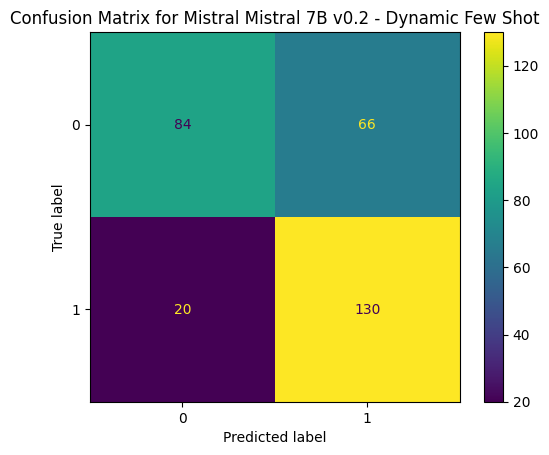

In [66]:
y_pred = [process_response(response) for response in dynamic_responses_v2]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Mistral Mistral 7B v0.2 - Dynamic Few Shot")
plt.show()

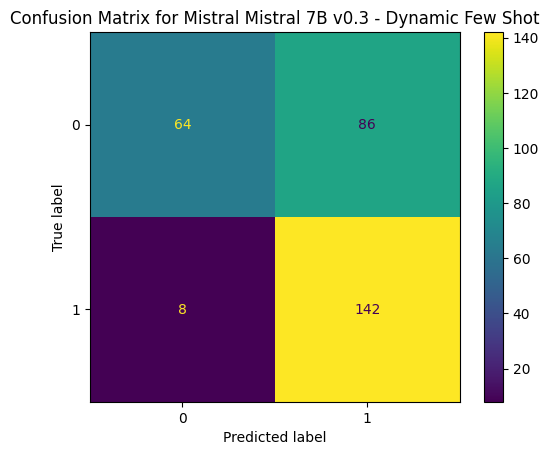

In [67]:
y_pred = [process_response(response) for response in dynamic_responses_v3]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix for Mistral Mistral 7B v0.3 - Dynamic Few Shot")
plt.show()

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End